In [37]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.sys.path.append('../../evaluation/')
import pickle
import numpy as np
import pandas as pd
import methods
import metrics
import tensorflow as tf
from scipy.stats import spearmanr

data_path = '../../data/simulated_1d/test/'
model_path = './model/'
gmm_path = './predictions_gmm.pkl'


In [38]:
# load data
data = pickle.load(open(data_path+'/input_data.pkl', 'rb'))
targets = pickle.load(open(data_path+'/target_data.pkl', 'rb'))
targets = [
    metrics.output_to_stats_1d(i) for i in targets
]

In [39]:
# predict GMM

if os.path.exists(gmm_path):
    p_gmm = pickle.load(open(gmm_path, 'rb'))
else:
    p_gmm = []
    for c,i in enumerate(data):
        if c%200==0:
            print(c)
        p = methods.predict_gmm(i)
        p_gmm.append([p['mean'], p['covariance']])

with open(gmm_path, 'wb') as f:
    pickle.dump(p_gmm, f)
    
# compute error
errors_gmm = metrics.get_errors(targets, p_gmm)


In [40]:
# predict NN

os.sys.path.append(model_path)
from predict import extract_features

# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))

# extract features
features = np.stack([extract_features(i) for i in data])
features = features[..., np.newaxis]

# predict
p_nn = model.predict(features)
p_nn = scalery.inverse_transform(p_nn) # scale outputs

p_nn = [
    metrics.output_to_stats_1d(i) for i in p_nn
]

# compute error
errors_nn = metrics.get_errors(targets, p_nn)


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


32/32 [==============================] - 0s 1ms/step


In [41]:
def get_error_statistics(errors, acc_threshold=0.98):
    """ Get error statistics
    """
    df = pd.DataFrame({
        'mean_bd': [np.mean(i) for i in errors.values()],
        'median_bd': [np.quantile(i, 0.5) for i in errors.values()],
        'acc_bc_'+str(acc_threshold): [len(np.where(np.exp(-i)>=acc_threshold)[0])/len(i) for i in errors.values()],
    })
    return df


In [42]:
errors = {
    'GMM': errors_gmm,
    'NN': errors_nn
}

df = get_error_statistics(errors)
df.index = errors.keys()
df


,mean_bd,median_bd,acc_bc_0.98
GMM,0.015462,0.004134,0.814
NN,0.005926,0.001664,0.930


In [43]:
with open('./errors.pkl', 'wb') as f:
    pickle.dump(errors, f)
    

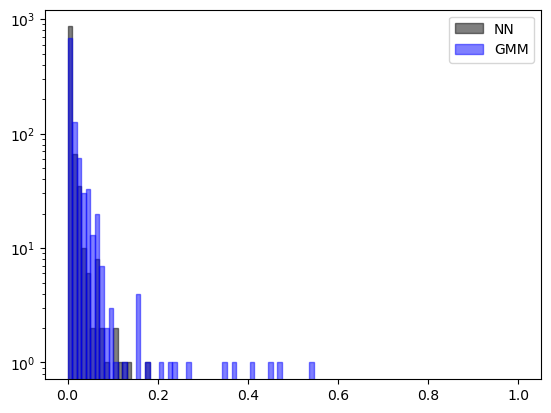

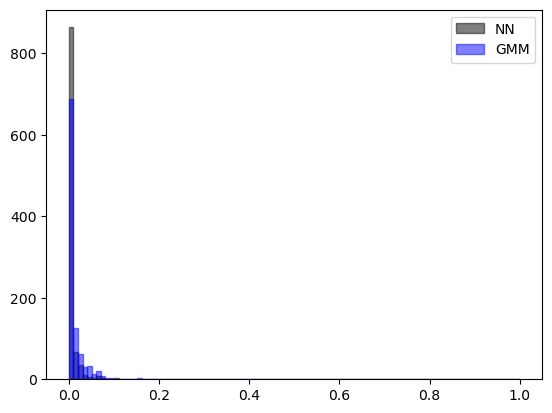

In [44]:
import matplotlib.pyplot as plt

plt.hist(errors['NN'], np.linspace(0, 1.0, 100), edgecolor='k', color='k', alpha=0.5, label='NN');
plt.hist(errors['GMM'], np.linspace(0, 1.0, 100), edgecolor='b', color='b', alpha=0.5, label='GMM');
plt.yscale('log')
plt.legend();

plt.figure()
plt.hist(errors['NN'], np.linspace(0, 1, 100), edgecolor='k', color='k', alpha=0.5, label='NN');
plt.hist(errors['GMM'], np.linspace(0, 1, 100), edgecolor='b', color='b', alpha=0.5, label='GMM');
plt.legend();


In [45]:
sizes = pickle.load(open(data_path+'/sizes.pkl', 'rb'))
means = pickle.load(open(data_path+'/means.pkl', 'rb'))
stds = pickle.load(open(data_path+'/stds.pkl', 'rb'))


In [46]:
ref_fracs = [i[0]/sum(i) for i in sizes]

bd_dists = []
for i in range(len(data)):
    if len(sizes[i])-1==2:
        bd_dists.append(
            metrics.bhattacharyya_gaussian_distance(
                means[i][0],
                np.array([stds[i][0]]),
                means[i][1],
                np.array([stds[i][1]]),
            )
        )
    else:
        bd_dists.append(
            np.mean([
                metrics.bhattacharyya_gaussian_distance(
                    means[i][0],
                    np.array([stds[i][0]]),
                    means[i][1],
                    np.array([stds[i][1]]),
                ),
                metrics.bhattacharyya_gaussian_distance(
                    means[i][0],
                    np.array([stds[i][0]]),
                    means[i][2],
                    np.array([stds[i][2]]),
                )
            ])
        )


In [47]:
with open('./ref_fracs.pkl', 'wb') as f:
    pickle.dump(ref_fracs, f)
with open('./bd_dists.pkl', 'wb') as f:
    pickle.dump(bd_dists, f)
    

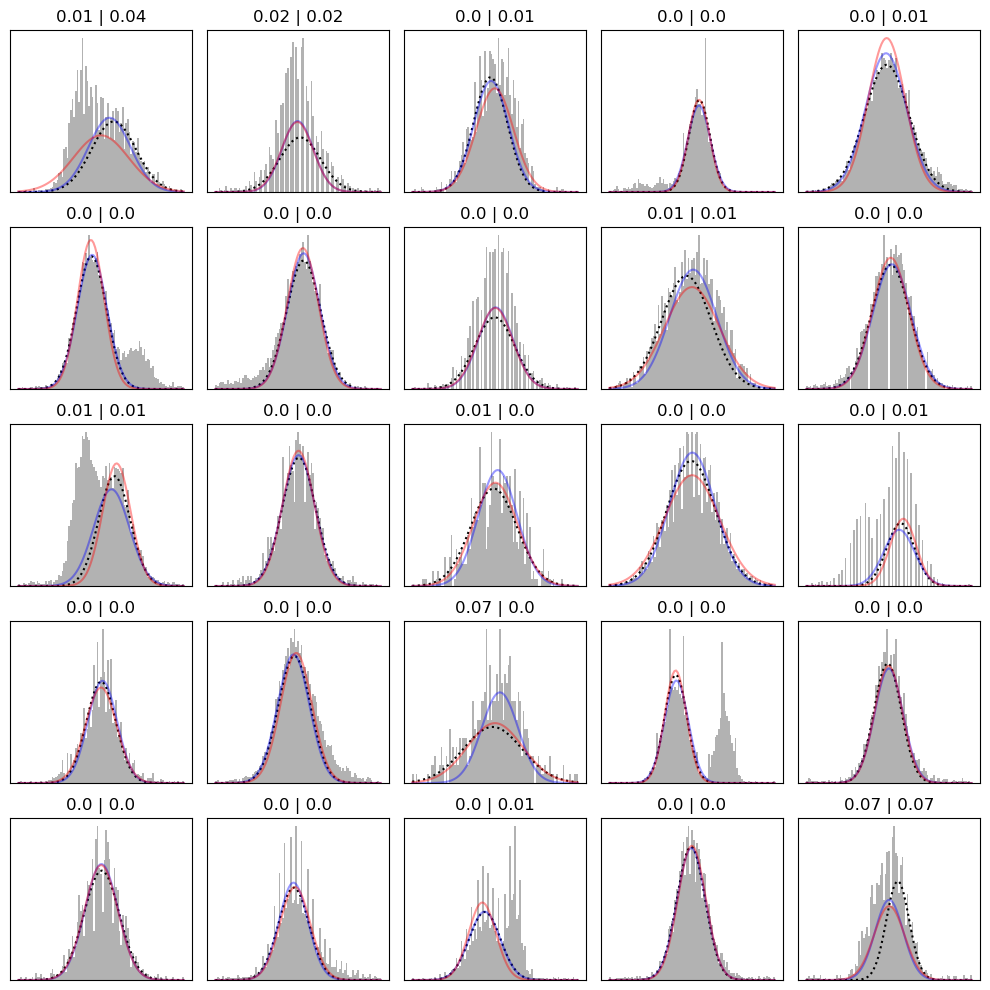

In [48]:
# check predictions

from scipy.stats import norm
# from sklearn.mixture import GaussianMixture

nr = 5
nc = 5

plt.figure(figsize=(10, 10))
x_range = np.linspace(-3, 3, 100)
idxs = np.random.choice(len(data), nr*nc)
idxs[0] = 740
for i in range(nr*nc):

    plt.subplot(nr, nc, i+1)
    idx = idxs[i]
    plt.hist(data[idx], x_range, color='k', alpha=0.3, density=True);

    # target
    pdf = norm(loc=targets[idx][0], scale=np.sqrt(targets[idx][1].squeeze())).pdf(x_range)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range, pdf, c='k', linestyle=':', label='target')
    
    # nn
    pdf = norm(loc=p_nn[idx][0], scale=np.sqrt(p_nn[idx][1].squeeze())).pdf(x_range)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range, pdf, c='b', label='target', alpha=0.4)
    
    # gmm
    pdf = norm(loc=p_gmm[idx][0], scale=np.sqrt(p_gmm[idx][1].squeeze())).pdf(x_range)
    pdf *= sizes[idx][0]/sum(sizes[idx])
    plt.plot(x_range, pdf, c='r', label='target', alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    
#     plt.title(round(np.exp(-bd_dists[idx]), 3));
    plt.title(str(round(errors['NN'][idx], 2))+' | '+str(round(errors['GMM'][idx], 2)))
    
plt.tight_layout()
    

## Checking GMM predictions

In [49]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# define GMM prediction
def predict_gmm(data, max_n_components=4, init_weights=True, bic_logic=True, target_n_components=None):

    fits = [] # for saving fits with different n_components
    bics = [] # for saving BIC of each fit
    for n_components in range(1,max_n_components+1): # test several numbers of components
        
        weights_init=None # when testing >1 component, initialize weights so one component has majority (reference)
        if n_components>1 and init_weights:
            weights_init=[0.55, *(0.45/(n_components-1),)*(n_components-1)] 
        
        gm = GaussianMixture( # fit GMM
            n_components=n_components, 
            weights_init=weights_init,
            max_iter=1000,
            random_state=0
        ).fit(data)
        
        fits.append(gm) # save results
        bics.append(gm.bic(data))

    if target_n_components is not None:
        gm = fits[target_n_components-1]
    elif bic_logic:
        if 1-min(bics)/max(bics)<0.03: # if there is not a significant difference in BICs use 1 component - likely a very low pathological fraction
            gm = fits[0]
        else:
            gm = fits[np.argmin(bics)] # get best fit based on BIC
    else:
        gm = fits[np.argmin(bics)] # get best fit based on BIC

    best_component = np.argmax(gm.weights_) # get main component based on weights
    
    mean = gm.means_[best_component] # retrieve statistics
    cov = gm.covariances_[best_component] # for 2d outputs
    
    result_dict = {
        'mean': mean, 
        'covariance': cov,
        'gmm_model': gm,
        'fits': fits,
        'bics': bics
    }
    
    return result_dict


In [50]:
idx = 492
idx = 934
idx = 808
idx = 473
idx = 118
idx = 740
# idx = 622
# idx = 11
# idx = 583


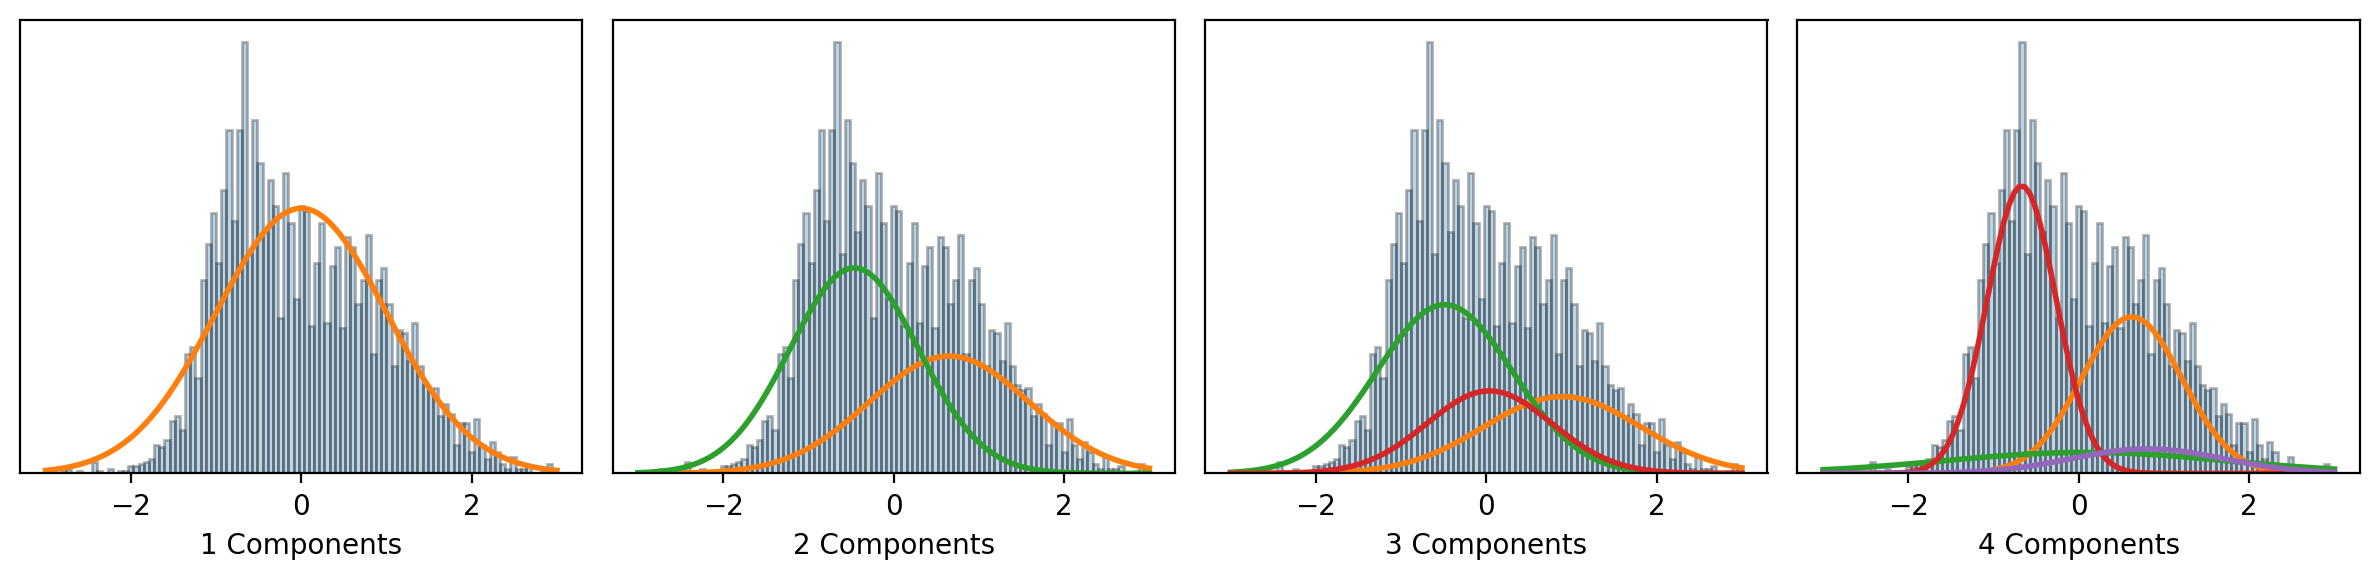

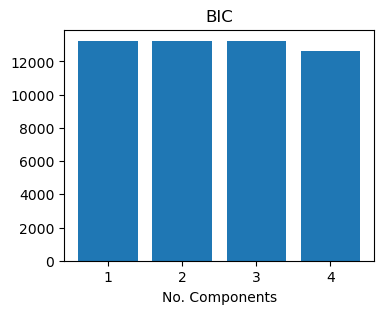

In [51]:
test = data[idx]

p = predict_gmm(test)

plt.figure(figsize=(12, 3), dpi=200)
for i in range(len(p['fits'])):
    fit = p['fits'][i]
    plt.subplot(1,len(p['fits']),i+1)
    plt.hist(test, x_range, density=True, edgecolor='k', alpha=0.3)
    plt.xlabel(str(i+1)+' Components')
    for c in range(len(fit.means_)):
        plt.plot(
            x_range,
            norm(fit.means_[c], np.sqrt(fit.covariances_[c,0,0])).pdf(x_range)*fit.weights_[c],
            linewidth=2
        )
    plt.yticks([])
plt.tight_layout()
plt.figure(figsize=(4, 3))
plt.bar(np.arange(len(p['fits']))+1, p['bics']);
plt.title('BIC')
plt.xlabel('No. Components');


In [52]:
p['bics']


[13213.017603802944, 13225.35229387571, 13245.726934754523, 12644.970568221923]

In [53]:
p['fits'][-1].weights_


array([0.34829497, 0.13108878, 0.43844178, 0.08217447])

In [54]:
bics = p['bics']
def best_fit(bics, improvement_per_component=0.02):
    best_fit = 1
    best_bic = float('inf')
    for i in range(len(bics)):
        if (1-bics[i]/best_bic) > improvement_per_component*(i+1-best_fit):
            best_bic = bics[i]
            best_fit = i+1
        else:
            continue
    return best_fit

def best_fit(bics, weights, improvement_per_component=0.02, active_min_weight=0.10):
    best_fit = 0
    best_bic = float('inf')
    active_components = [len(np.where(i>=active_min_weight)[0]) for i in weights]
    for i in range(len(bics)):
        if (1-bics[i]/best_bic) > improvement_per_component*(active_components[i]-active_components[best_fit]):
            best_bic = bics[i]
            best_fit = i
        else:
            continue
    return best_fit

best_fit(p['bics'], [i.weights_ for i in p['fits']])
    

3